In [7]:
import pandas as pd
import numpy as np
from skimage.io import imread,imsave, imshow
from skimage.color import rgb2gray, gray2rgb
import matplotlib.pyplot as plt

from skimage.io import imread,imsave
from PIL import Image
import math

import torch
import torchvision
import torchvision.transforms as transforms

In [8]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
def alargamento_de_contraste(imagem, k, e):
    altura, largura = imagem.shape

    # Aplica a função de atenuação para cada pixel da imagem
    for i in range(altura):
        for j in range(largura):
            imagem[i, j] = 1/(1+((k/imagem[i, j])**e))

    return imagem

class alargamento_de_contraste_torch(object):

    def __init__(self, k, e):
      self.k = k
      self.e = e

    def __call__(self, imagem):
      altura, largura, _ = imagem.shape

      # Aplica a função de atenuação para cada pixel da imagem
      for i in range(altura):
          for j in range(largura):
              imagem[i, j] = 1/(1+((self.k/imagem[i, j])**self.e))

      return imagem

In [15]:
transform = transforms.Compose(
    [transforms.ToTensor(), alargamento_de_contraste_torch(1,2)])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=6,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=6,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


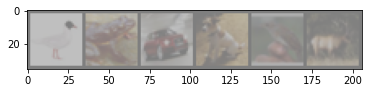

 bird  frog   car   dog


In [16]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap="gray")
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [17]:
import torch.nn as nn
import torch.nn.functional as F


# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net()

class classificador(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3))
    self.conv2 = nn.Conv2d(32, 32, (3, 3))
    self.activation = nn.ReLU()
    self.bnorm = nn.BatchNorm2d(num_features=32)
    self.pool = nn.MaxPool2d(kernel_size=(2, 2))
    self.flatten = nn.Flatten()

    # output = (input - filter + 1) / stride
    # convolução 1: (32 - 3 + 1) / 1 = 30x30
    # pooling 1: 15x15
    # convolução 2: (15 - 3 + 1) / 1 = 13x13
    # pooling 2: 6x6
    # 6 * 6 * 32
    # 800 -> 128 -> 128 -> 10
    self.linear1 = nn.Linear(in_features=32*6*6, out_features=128)
    self.linear2 = nn.Linear(128, 128)
    self.output = nn.Linear(128, 10)
    self.dropout = nn.Dropout(p=0.2)

  def forward(self, X):
    X = self.pool(self.bnorm(self.activation(self.conv1(X))))
    X = self.pool(self.bnorm(self.activation(self.conv2(X))))
    X = self.flatten(X)

    X = self.dropout(self.activation(self.linear1(X)))
    X = self.dropout(self.activation(self.linear2(X)))
    X = self.output(X)

    return X


net = classificador()

In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [19]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.765
[1,  4000] loss: 1.491
[1,  6000] loss: 1.365
[1,  8000] loss: 1.321
[2,  2000] loss: 1.201
[2,  4000] loss: 1.188
[2,  6000] loss: 1.144
[2,  8000] loss: 1.138
[3,  2000] loss: 1.041
[3,  4000] loss: 1.051
[3,  6000] loss: 1.034
[3,  8000] loss: 1.041
[4,  2000] loss: 0.943
[4,  4000] loss: 0.952
[4,  6000] loss: 0.952
[4,  8000] loss: 0.952
[5,  2000] loss: 0.870
[5,  4000] loss: 0.889
[5,  6000] loss: 0.884
[5,  8000] loss: 0.875
Finished Training


In [20]:
PATH = './cifar_net_alargamento_de_contraste_torch.pth'
torch.save(net.state_dict(), PATH)

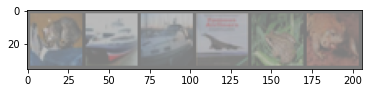

GroundTruth:    cat  ship  ship plane


In [21]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [22]:
outputs = net(images)

In [23]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [24]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 64 %


In [25]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 65 %
Accuracy of   car : 74 %
Accuracy of  bird : 52 %
Accuracy of   cat : 42 %
Accuracy of  deer : 70 %
Accuracy of   dog : 53 %
Accuracy of  frog : 75 %
Accuracy of horse : 66 %
Accuracy of  ship : 83 %
Accuracy of truck : 72 %
